In [1]:
import sys
import os
import glob
import pandas as pd
import numpy as np
import json
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from matplotlib import pyplot as plt
from nilearn.masking import apply_mask
sys.path.append('..')
from utils.data import load_participant_list

# Parameters

In [2]:
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rl_modulation_20250126'

# Load ROI masks

In [10]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Load First level data

In [3]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [4]:
first_level_params = json.load(open(os.path.join(first_level_dir, 'sub-01', f'run-{run}', f'sub-01_run-{run}_params.json')))
for key, value in first_level_params.items():
    print(f"{key}: {value}")

model_name: rl_modulation
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
high_pass: 0.01
motion_type: basic
include_physio: True
brain_mask: False
mask_samples: False
demean_modulator: True


# Second level

In [8]:
rl_betamaps_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}",f"run-{run}",f"beta_*_first_stim_presentation.nii.gz"))[0]
    for sub_id in sub_ids
]
rl_betamaps_paths.sort()

rl_betamaps = [image.load_img(path) for path in rl_betamaps_paths]

assert len(rl_betamaps) == len(sub_ids)

In [13]:
X_rl = pd.DataFrame([1] * len(rl_betamaps), columns=['RL_value'])

In [14]:
model_rl = SecondLevelModel().fit(rl_betamaps, design_matrix=X_rl)

In [15]:
rl_map = model_rl.compute_contrast(output_type='z_score')

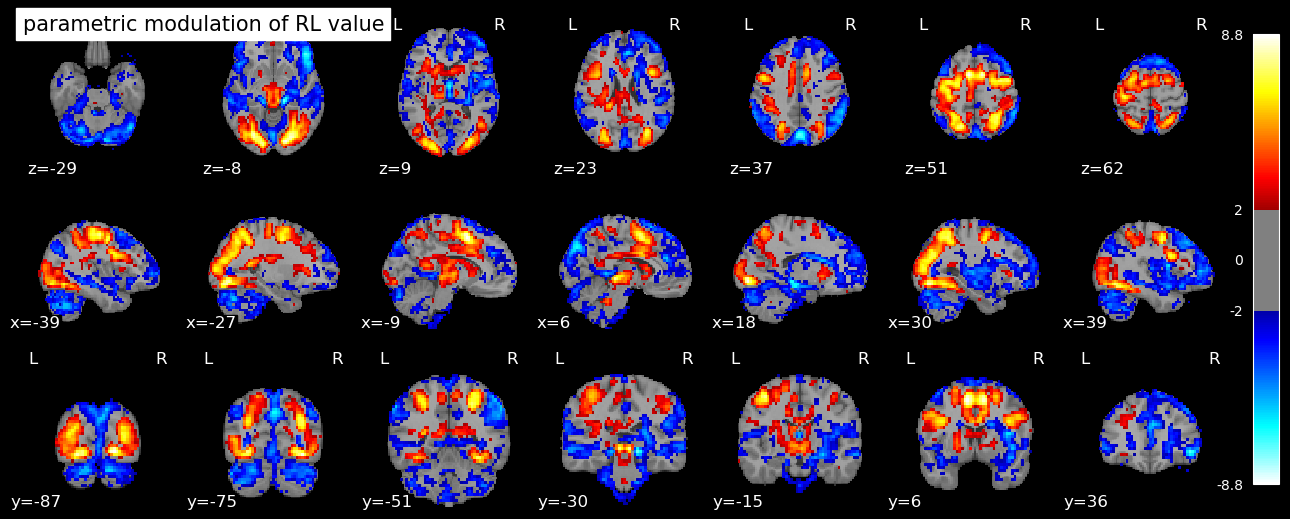

In [16]:
plot_stat_map(rl_map, threshold=2, black_bg=True, display_mode='mosaic', title='parametric modulation of RL value')

In [19]:
RL_WB_thresholded_zmap, RL_WB_threshold = threshold_stats_img(rl_map, alpha=0.05, height_control='bonferroni')
print(f"RL whole brain FDR threshold: {RL_WB_threshold:.3f}")

RL whole brain FDR threshold: 4.956


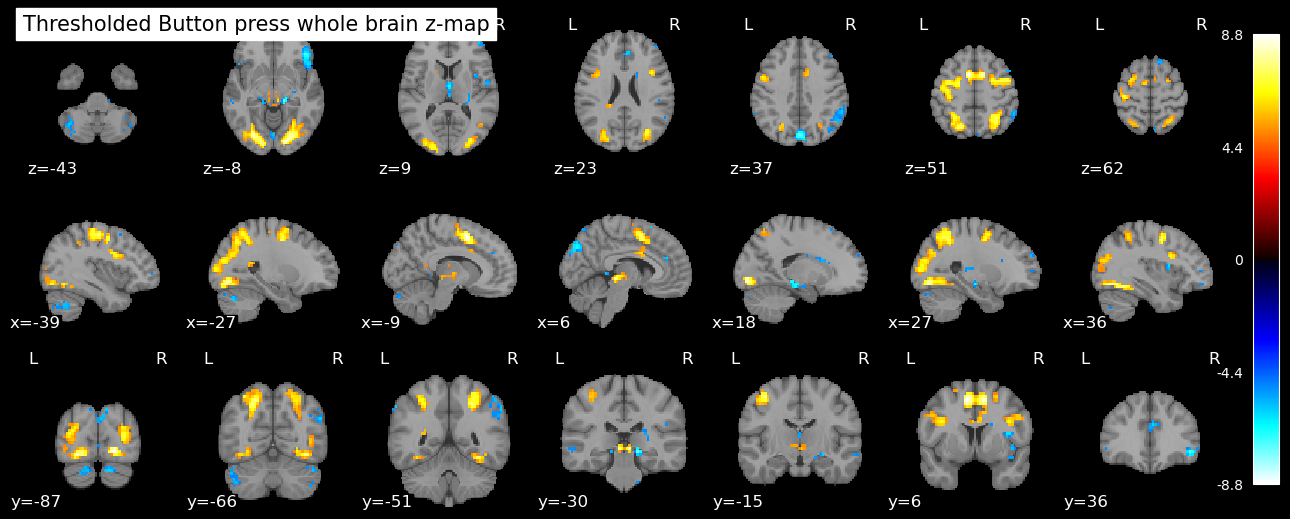

In [20]:
plot_stat_map(RL_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded Button press whole brain z-map')

# Second level - first stim presentation

In [12]:
betamaps_paths = [
    glob.glob(os.path.join(first_level_dir, f"sub-{sub_id}",f"run-{run}",f"beta_*_first_stim_presentation.nii.gz"))[0]
    for sub_id in sub_ids
]
betamaps_paths.sort()

betamaps_first_stim = [image.load_img(path) for path in betamaps_paths]

In [13]:
X_first_stim = pd.DataFrame([1] * len(betamaps_first_stim), columns=['Intercept'])

In [14]:
model2 = SecondLevelModel().fit(betamaps_first_stim, design_matrix=X_first_stim)

In [15]:
first_stim_map = model2.compute_contrast(output_type='z_score')

In [ ]:
plot_stat_map(first_stim_map, threshold=4, black_bg=True, display_mode='mosaic', title='Average effect of first stim presentation')

In [ ]:
thresholded_zmap, threshold = threshold_stats_img(first_stim_map, alpha=0.005, height_control='bonferroni')#, cluster_threshold=20)
print(f"Threshold: {threshold:.3f}")

In [ ]:
plot_stat_map(thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded 1st stim presentation whole brain z-map')